In [2]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

from config import DUCKDB_PATH

# global duckdb connection
con = duckdb.connect(DUCKDB_PATH)
AGG_COLUMNS = [
    'eth_type',
    'ip_src',
    'ip_dst',
]

# print number of attacks and non-attacks
sql = """
    SELECT * FROM merged_aggregated
"""
full_data = con.execute(sql).df()

full_data
con.close()

In [4]:

# print number of attacks and non-attacks
con = duckdb.connect(DUCKDB_PATH)
sql = """
    SELECT COUNT(*) AS num_attacks, attack_type
    FROM merged_aggregated
    GROUP BY attack_type
"""

result = con.execute(sql).df()

result
con.close()

<Figure size 500x300 with 0 Axes>

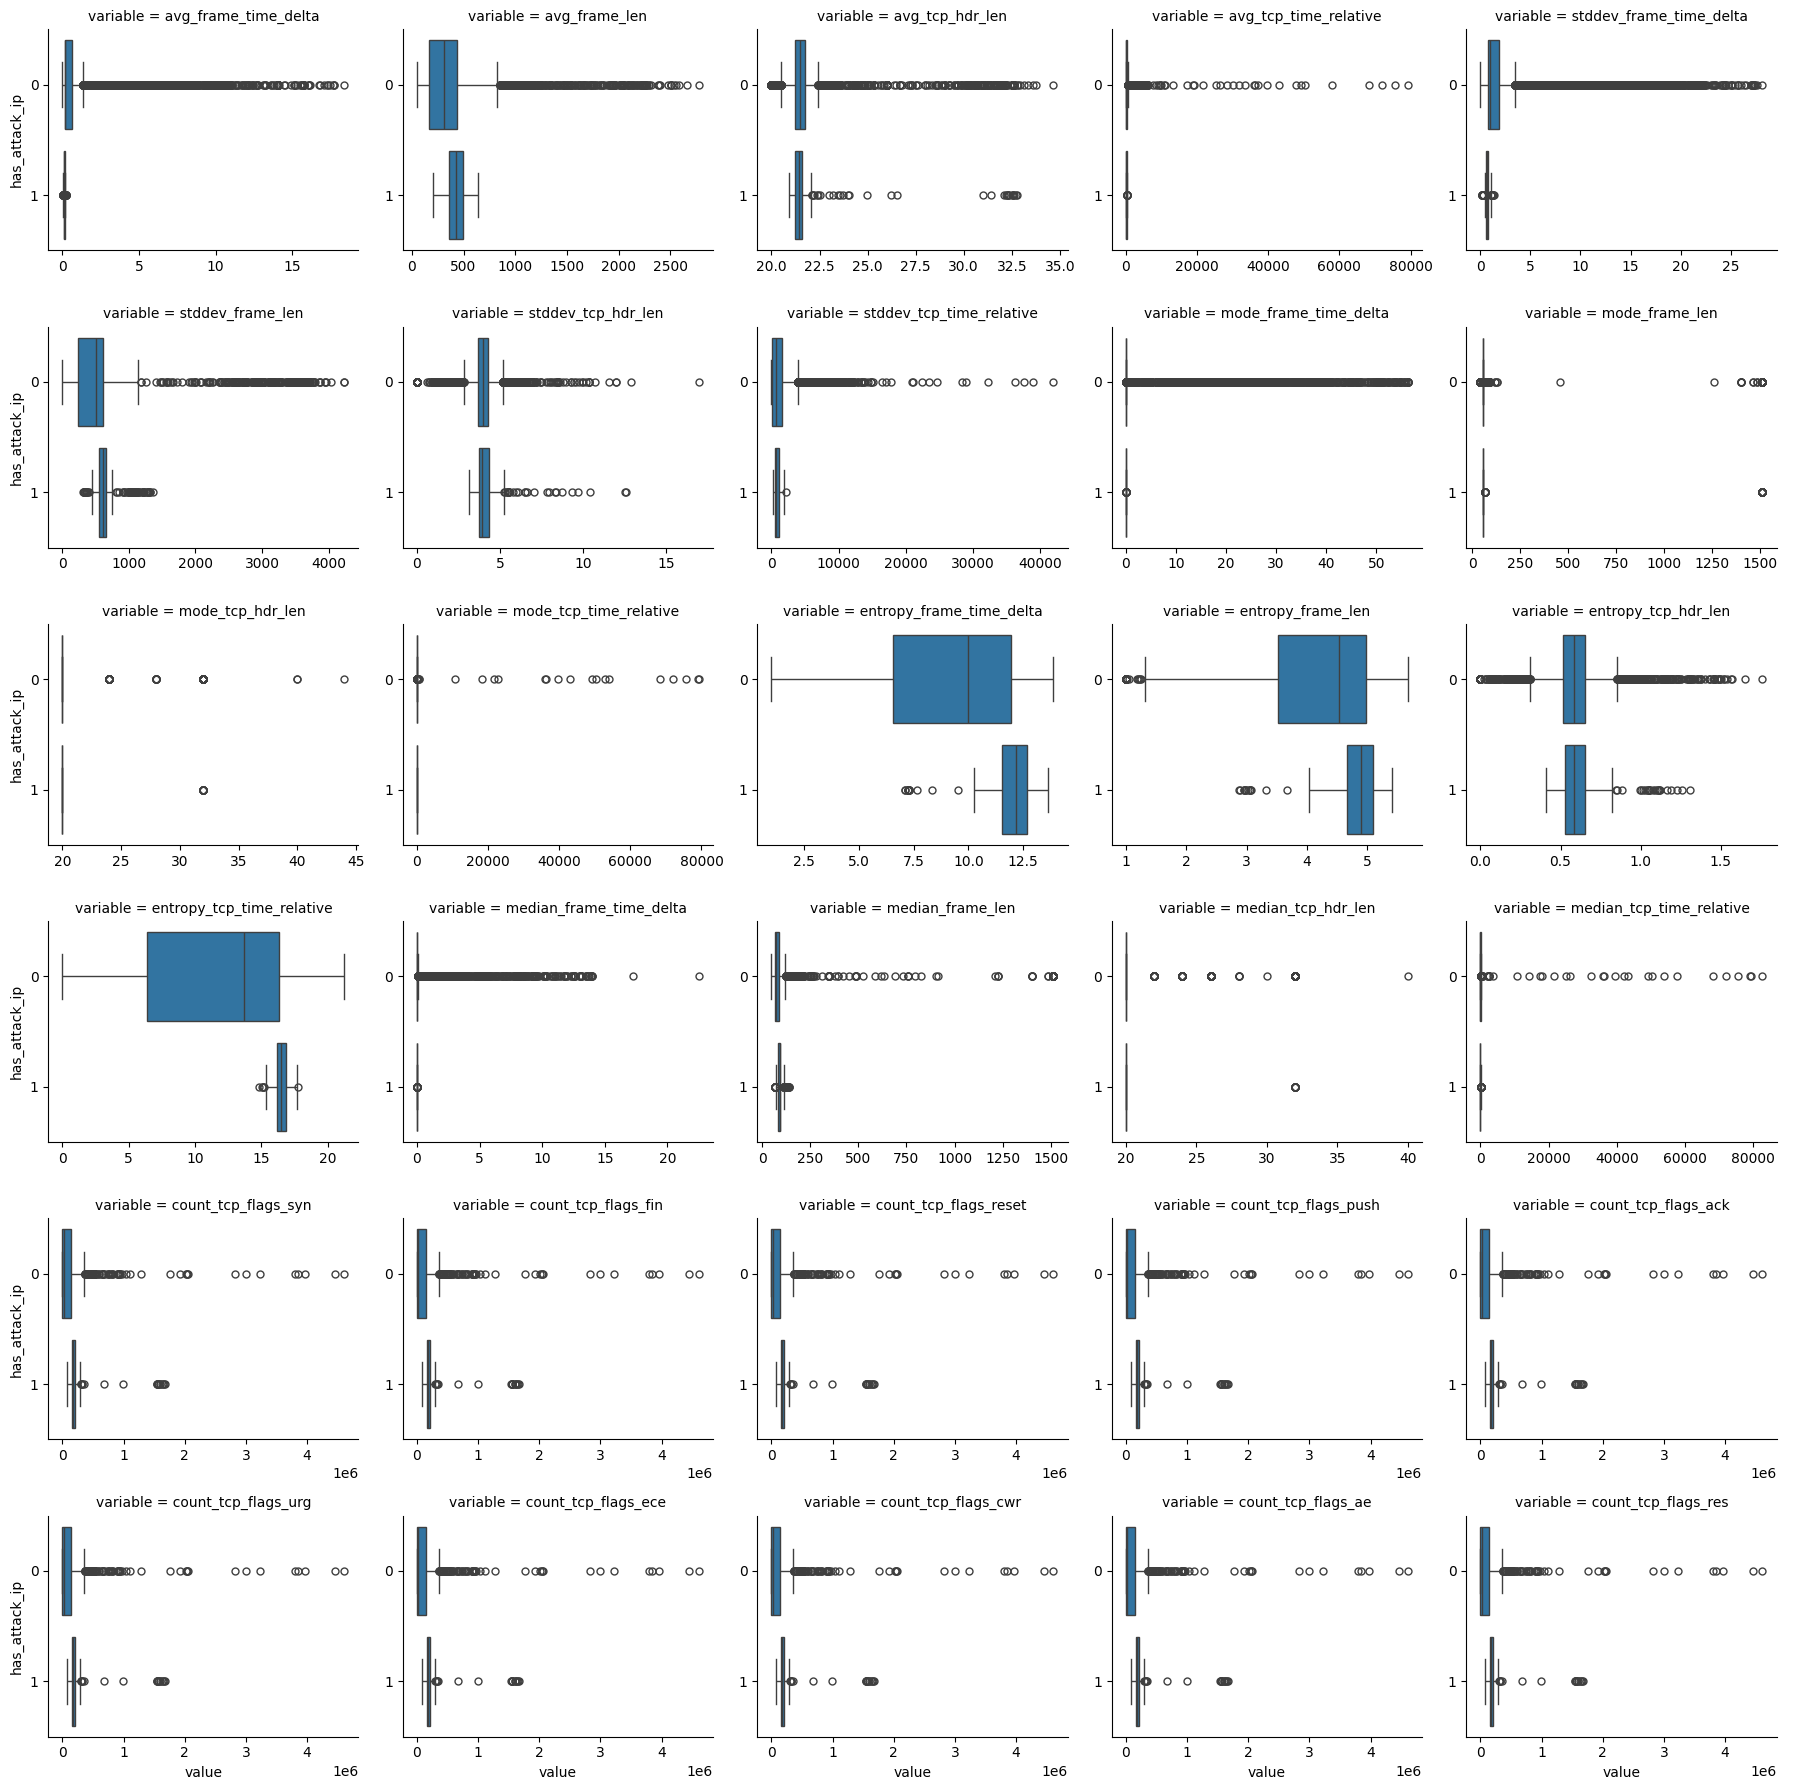

In [17]:
# look at some different features
from config import ATTACK_TYPE_MAPPING


plt.figure(figsize=(5, 3))
# pivot columns to longer format
bots_data_melt = full_data.melt(id_vars=['date_minutes', 'attack_type', 'is_attack', 'has_attack_ip'], value_vars=[
    'avg_frame_time_delta',
    'avg_frame_len',
    'avg_tcp_hdr_len',
    'avg_tcp_time_relative',
    
    'stddev_frame_time_delta',
    'stddev_frame_len',
    'stddev_tcp_hdr_len',
    'stddev_tcp_time_relative',
    
    'mode_frame_time_delta',
    'mode_frame_len',
    'mode_tcp_hdr_len',
    'mode_tcp_time_relative',
    
    'entropy_frame_time_delta',
    'entropy_frame_len',
    'entropy_tcp_hdr_len',
    'entropy_tcp_time_relative',
    
    'median_frame_time_delta',
    'median_frame_len',
    'median_tcp_hdr_len',
    'median_tcp_time_relative',
    
    'count_tcp_flags_syn',
    'count_tcp_flags_fin',
    'count_tcp_flags_reset',
    'count_tcp_flags_push',
    'count_tcp_flags_ack',
    'count_tcp_flags_urg',
    'count_tcp_flags_ece',
    'count_tcp_flags_cwr',
    'count_tcp_flags_ae',
    'count_tcp_flags_res',
    
    # 'count_proto_tcp',
    # 'count_proto_udp',
    # 'count_proto_tls',
    # 'count_proto_http',
    # 'count_proto_smb',
    # 'count_proto_rdp'
])

ATTACK_TYPE_MAPPING_INV = {v: k for k, v in ATTACK_TYPE_MAPPING.items()}
bots_data_melt['attack_type_str'] = bots_data_melt['attack_type'].map(ATTACK_TYPE_MAPPING_INV)

sns.catplot(
    data=bots_data_melt,
    y='has_attack_ip',
    x='value',
    kind='box',
    col='variable',
    orient='h',
    col_wrap=5,
    sharey=False,
    sharex=False,
    height=3,
    aspect=1.2,
    margin_titles=True,
)

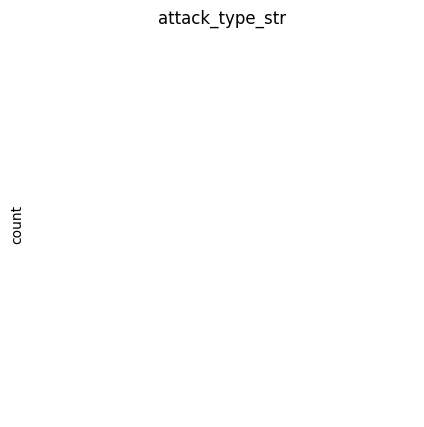

In [42]:
# also plot attack_type with pie chart for attack_types not equal to 0
ATTACK_TYPE_MAPPING_INV = {v: k for k, v in ATTACK_TYPE_MAPPING.items()}
full_data['attack_type_str'] = full_data['attack_type'].map(ATTACK_TYPE_MAPPING_INV)

# remove attack_type 0
data_no_benign = full_data[full_data['attack_type_str'] != 'benign']

plt.figure(figsize=(5, 5))
data_no_benign['attack_type_str'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('attack_type_str')
plt.show()